In [60]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


In [38]:
df = pd.read_csv('budget-data/budget-data-model-one-hot.csv')
df_model2 = df.copy()
df_model2.head()

,unit_price,Length,Height,Gutter,filter_efficiency_F7,filter_efficiency_F8,filter_efficiency_F9,filter_efficiency_G2,filter_efficiency_G3,filter_efficiency_G4,...,quote_id_211130.0,quote_id_220207.0,quote_id_220315.0,quote_id_220428.0,quote_id_220513.0,quote_id_220620.0,quote_id_230912.0,quote_id_2207061721.0,quote_id_2207221707.0,quote_id_2207291200.0
0,7.5,625.0,500.0,50.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,27.5,625.0,500.0,50.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28.5,592.0,490.0,48.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27.5,592.0,592.0,45.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,287.0,592.0,45.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df_G4 = df_model2[df_model2['filter_efficiency_G4'] == 1]
df_F7 = df_model2[df_model2['filter_efficiency_F7'] == 1]
df_M5 = df_model2[df_model2['filter_efficiency_M5'] == 1]

In [40]:
def scale_datasets(x_train, x_test):
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

In [59]:
def get_best_weights(name):

    # Specify the path of the directory
    directory_path = 'weights/'+name+'/'

    # Get a list of all files in the directory
    file_names = os.listdir(directory_path)

    # Print the list of file names
    best_weights = file_names[-1]
    return best_weights

In [67]:
dfs = [(df_G4, "G4"), (df_F7, "F7"), (df_M5, "M5"),(df_model2, "geral")]

columns = ['model','r2', 'mse', 'mae', 'rmse']
df_new = pd.DataFrame(columns=columns)

for value in dfs :
    checkpoint_name = 'weights/'+value[1]+'/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]

    x_train, x_test, y_train, y_test = train_test_split(value[0].drop(['unit_price'], axis=1), value[0]['unit_price'], test_size=0.2, random_state=42)
    x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

    # Creating model using the Sequential in tensorflow
    model = Sequential()

    # The Input Layer :
    model.add(Dense(128, kernel_initializer='normal',input_dim = x_train_scaled.shape[1], activation='relu'))

    # The Hidden Layers :
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # build the model
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    # train the model
    history = model.fit(
        x_train_scaled.values, 
        y_train.values, 
        epochs=500, 
        batch_size=32,
        validation_split=0.2, callbacks=callbacks_list
    )

    wights_file = get_best_weights(value[1]) # choose the best checkpoint 
    model.load_weights('weights/'+value[1]+'/'+wights_file) # load it
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    y_pred = model.predict(x_test_scaled.values)

    result = {
    'model': value[1],
    'r2': r2_score(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': math.sqrt(mean_squared_error(y_test, y_pred))
    }
    
    df_new = df_new.append(result, ignore_index=True)

df_new.to_csv('results/NeuralNet.csv', index=False)


19/19 [==============================] - 0s 4ms/step


C:\Users\João\AppData\Local\Temp\ipykernel_10628\657432247.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(result, ignore_index=True)


11/11 [==============================] - 0s 4ms/step


C:\Users\João\AppData\Local\Temp\ipykernel_10628\657432247.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(result, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


C:\Users\João\AppData\Local\Temp\ipykernel_10628\657432247.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(result, ignore_index=True)


38/38 [==============================] - 0s 4ms/step


C:\Users\João\AppData\Local\Temp\ipykernel_10628\657432247.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(result, ignore_index=True)


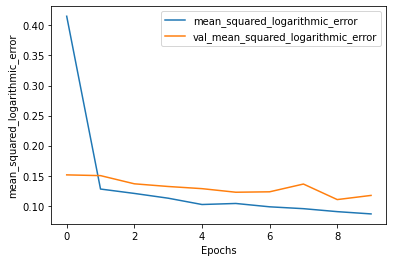

In [9]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')